In [18]:
from sklearn.metrics import (ConfusionMatrixDisplay,classification_report,confusion_matrix)
from sklearn.model_selection import GridSearchCV, train_test_split,cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline 
import matplotlib.pyplot as plt
from scipy.io.arff import loadarff 
import pickle
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('/home/mussie/Videos/exam_prep/data/churn-bigml-20.csv')

In [3]:
df.head(3)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True


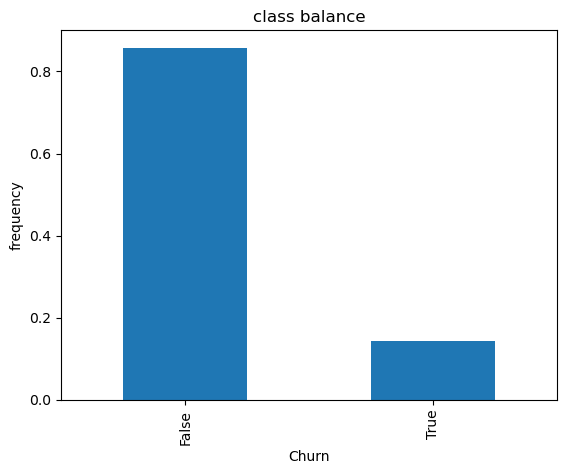

In [4]:
# Plot class balance
df['Churn'].value_counts(normalize=True).plot(
    kind="bar",xlabel='Churn',ylabel='frequency',title='class balance'
); 
  

In [5]:
feature = ['Account length', 'Area code',
         'Total day minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls' ]
target= ['Churn']

X = df[feature]
y =df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (667, 6)
y shape: (667, 1)


In [6]:
X_train, X_test, y_train, y_test = X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [7]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (533, 6)
y_train shape: (533, 1)
X_test shape: (134, 6)
y_test shape: (134, 1)


In [8]:
#counting values
y_train.value_counts()

Churn
False    453
True      80
dtype: int64

In [9]:
over_sampler = RandomOverSampler()
X_train_o, y_train_o = over_sampler.fit_resample(X_train,y_train)
print("X_train_over shape:", X_train_o.shape)
X_train_o.head(2)

X_train_over shape: (906, 6)


,Account length,Area code,Total day minutes,Total intl calls,Total intl charge,Customer service calls
0,55,510,189.0,6,4.62,0
1,100,408,70.8,1,2.57,6


In [13]:
y_train_o.shape

(906, 1)

In [14]:
# create an instance of LabelEncoder
le = LabelEncoder()

# fit and transform the encoder to the target variable
y_train = le.fit_transform(y_train_o)
y_test = le.transform(y_test)

/home/mussie/anaconda3/envs/exam/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
from sklearn.preprocessing import LabelEncoder

# create an instance of LabelEncoder
le = LabelEncoder()

# reshape target variables to avoid DataConversionWarning
y_train = y_train_o['Churn'].values.reshape(-1, 1)
y_test = y_test['Churn'].values.reshape(-1, 1)

# fit and transform the encoder to the target variable
y_train = le.fit_transform(y_train.ravel())
y_test = le.transform(y_test.ravel())

In [15]:
import numpy as np

# calculate the frequency of each label
counts = np.bincount(y_train)

# calculate the baseline accuracy as the fraction of the most frequent label
acc_baseline = counts.max() / len(y_train)

print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.5


In [16]:

knn = KNeighborsClassifier()
params_knn = {'n_neighbors': np.arange(1, 25)}
knn_gs = GridSearchCV(knn, params_knn, cv=5)
knn_gs.fit(X_train_o,y_train)
knn_best = knn_gs.best_estimator_


In [24]:
knn_best

KNeighborsClassifier(n_neighbors=8)

In [17]:
rf = RandomForestClassifier(random_state=0)
params_rf = {'n_estimators': [50, 100, 200]}
rf_gs = GridSearchCV(rf, params_rf, cv=5)
rf_gs.fit(X_train_o,y_train)
rf_best = rf_gs.best_estimator_


In [19]:
log_reg = LogisticRegression(random_state=123, solver='liblinear', penalty='l2', max_iter=5000)
C = np.logspace(1, 4, 10)
params_lr = dict(C=C)
lr_gs = GridSearchCV(log_reg, params_lr, cv=5, verbose=0)
lr_gs.fit(X_train_o,y_train)
lr_best = lr_gs.best_estimator_


In [20]:
from sklearn.ensemble import VotingClassifier
estimators = [('knn', knn_best), ('rf', rf_best), ('log_reg', lr_best)]
ensemble = VotingClassifier(estimators, voting='soft')
ensemble.fit(X_train_o,y_train)


VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=1)),
                             ('rf',
                              RandomForestClassifier(n_estimators=200,
                                                     random_state=0)),
                             ('log_reg',
                              LogisticRegression(C=46.41588833612777,
                                                 max_iter=5000,
                                                 random_state=123,
                                                 solver='liblinear'))],
                 voting='soft')

In [21]:
y_pred = ensemble.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

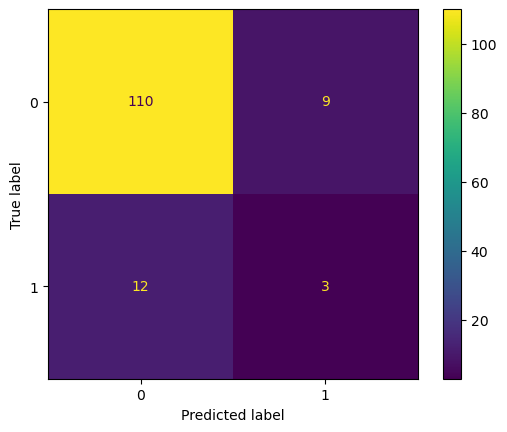

In [22]:
#plot a confusion matrix that shows how your best model performs on your test set.
ConfusionMatrixDisplay.from_estimator(ensemble,X_test,y_test)    
     

In [23]:
# compute the classification report
report = classification_report(y_test, y_pred, target_names=['No churn', 'Churn'])

# print the report
print(report)

              precision    recall  f1-score   support

    No churn       0.90      0.92      0.91       119
       Churn       0.25      0.20      0.22        15

    accuracy                           0.84       134
   macro avg       0.58      0.56      0.57       134
weighted avg       0.83      0.84      0.84       134



In [24]:
#saving model to a file
with open("model.1.pkl","wb") as f:
  pickle.dump(ensemble,f)